# 第３章

前章から引き続き単語の分散表現について学ぶ。<br>
前章では**カウントベース**によって単語の分散表現を得た。<br>
本章ではその代わりとして**推論ベースの手法**について学ぶ。<br>

**推論ベースの手法**：名前のとおり推論をする手法でニューラルネットワークが使える。<br>
                    ここでは**word2vec**について実装し理解を深める。

## 3.1 推論ベースの手法とニューラルネットワーク

単語をベクトルで表す手法はこれまで盛んに行われ、その中でも成功した手法は**カウントベースの手法**と**推論ベースの手法**。
両者はアプローチの仕方が異なるが背景にはともに**分布仮説**がある。<br>

ここではカウントベース手法の問題点を指摘しそれに代わる推論ベース手法の利点を説明する。<br>
その後、word2vecの下準備をするために、ニューラルネットワークで「単語」を処理する例をみる。

## 3.1.1 カウントベースの手法の問題点

＜復習＞
単語の共起行列を作りその行列に対してSVDを適用することで単語の分散表現を獲得するもの。

**カウントベース手法の問題点**：大規模なコーパスを扱う時に巨大な行列を作ることになり、これに対してSVDを行うことは現実的ではない。（n*n行列に対しn^3の大きさに比例した計算時間がかかる）

- カウントベースの手法：コーパス全体の統計データを利用して１回の処理で単語の分散表現を獲得
- 推論ベースの手法：ニューラルネットワークを用いる場合はミニバッチで学習

一度に少量の学習サンプルを見ながら、重みを繰り返し更新する。枠組みの違いは以下の通り

<img src="zerotuku2-3-1.png">

ここで推論ベースの強い点は計算量が膨大で処理が困難な場合でも<br>
データを小分けにして学習ができる点。<br>
また、ニューラルネットワークでは複数のマシン・GPUによる並列計算が可能で<br>
全体の学習を高速化できる。

## 3.1.2 推論ベースの手法の概要

推論ベースの手法では「推論」が主な作業になる。周囲の単語が与えられたときにどのような単語が得られるかを推測する。<br>
このときモデル視点にたつとこの推論問題は以下のようにみえる。

<img src="zerotuku2-3-3.png">

この図からわかるとおり推論ベースの問題では何らかのモデルが登場する。<br>
私達はそのモデルにニューラルネットワークを使う。<br>
モデルにはコンテキスト情報を入力として受取り、各単語の出現する確率を出力する。<br>
その枠組みの中で正しい推測ができるようにコーパスを使ってモデルの学習を行う。<br>
その結果として、単語の分散表現を得るということが<br>
推論ベースの手法の全体図となる。

## 3.1.3 ニューラルネットワークの単語の処理方法

これからニューラルネットワークを使って「単語」を処理する。<br>
ニューラルネットワークは単語をそのまま処理できないのでベクトルに変換する。
手法の一つとして**one-hot表現**がある。<br>
これはベクトルの要素の中で一つだけが１で残りはすべて０であるようなベクトルを意味する。

たとえば「You say goodbye and I say hello.」に対して各単語を変換すると<br>
you　→　(1,0,0,0,0,0,0)<br>
goodbye　→　(0,0,1,0,0,0,0)<br>
このように単語を固定長のベクトルにすればニューラルネットワークの入力層は<br>
以下のように固定することができる。

<img src="zerotuku2-3-5.png">

此の操作によって単語をベクトルで表せるようになったので<br>
そのベクトルはニューラルネットワークを構成する<br>
様々な「レイヤ」によって処理することが可能になる。

全結合層はすべてのノードに矢印によるつながりがある。<br>
此の矢印にはすべて重みがあり入力層のニューロンとの重み付き和が<br>
中間層のニューロンとなる。<br>
本章ではバイアスに関しては省略。

重みを明確に示すため、以下のような記法を用いる。

<img src="zerotuku2-3-7.png">

これまでの話をコードベースで見る。<br>
入力層から中間層への変換は以下の通り<br>

今回はできる限りtensorflowを導入する。<br>
tensorflow：Googleが開発したオープンソースの機械学習（ML）/深層学習（DL）ライブラリ <br>

メリット
- 自動微分で勾配計算が可能
- 学習済みのモデルを再利用可能

In [3]:
import numpy as np

c=np.array([[1,0,0,0,0,0,0]])#ここでは'you'に対応
W=np.random.randn(7,3)#全結合層
h=np.dot(c,W)
print(h)

[[0.36355711 0.96910709 0.55053795]]


tensorflowではdotが定義されていないため注意<br>
ここでは行列の積としてmatmulを利用。

In [28]:
import tensorflow as tf

# TensorFlowのTensorで置き換え
c = tf.constant([[1, 0, 0, 0, 0, 0, 0]], dtype=tf.float32)
W = tf.random.normal((7, 3))
h = tf.matmul(c, W)#今回はベクトルの積のためdotと同じ
print(h.numpy())

2025-07-10 01:20:14.258351: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[ 1.0934327  -0.66626     0.21555054]]


tensorflowでなくても第一章でしたMatMulレイヤで行うことも可能<br>
実装すると以下の通り

In [11]:
import sys
sys.path.append('..')
import numpy as np
from layers import MatMul

c=np.array([[1,0,0,0,0,0,0]])
W=np.random.randn(7,3)
layer=MatMul(W)
h=layer.forward(c)
print(h)

[[ 0.1308704  -1.01777596 -0.76245256]]


In [43]:
#tensorflow
import tensorflow as tf

class MatMulTF:
    def __init__(self, W):
        self.W = tf.Variable(W, dtype=tf.float32)  # 学習するなら Variable（勾配をとって更新）

    def forward(self, x):
        # 入力 x も Tensor にしておく
        return tf.matmul(x, self.W)

# One-hot 入力
c = tf.constant([[1, 0, 0, 0, 0, 0, 0]], dtype=tf.float32)
# 重み
W = tf.random.normal((7, 3))
# レイヤー
layer = MatMulTF(W)
# フォワード
h = layer.forward(c)
print(h.numpy())

[[-0.5618721 -1.6692069 -1.2896522]]


# 3.2 シンプルなword2vec

推論ベースの手法を学び、ニューラルネットワークにおける単語の処理方法について<br>
コードベースでみた。<br>
ここからword2vecの実装に取り掛かる。<br>
これからは「モデル」にニューラルネットワーク組み込む。<br>
ここでは、**continuous baf-of-words**と呼ばれるモデルを使う。<br>

## 3.2.1 CBOWモデルの推論処理

CBOWモデル：コンテキストからターゲットを推測することを目的としたニューラルネットワーク。<br>
このモデルをできるだけ正確な推測ができるように訓練することで<br>
単語の分散表現を獲得することができる。<br>

CBOWモデルへの出力はコンテキストで、単語のリストとして表される。<br>
これをone-hot表現に変換することでCBOWモデルが処理できるように調整する。<br>


<img src="zerotuku2-3-9.png">

上の図がCBOWモデルのネットワーク。入力層が２つあり、中間層を経て出力層に行く。<br>
入力層から中間層までの全結合層は同じもの$(W_{in})$を利用し<br>
中間層から出力層への全結合層は別のもの$(W_{out})$を利用する。<br>
ここでは入力層が２つあるが一般にコンテキストとしてN個の単語がある場合<br>
入力層はN個存在する。（one-hotの性質）<br>

中間層にあるニューロンは各入力層の<br>
全結合による変換の値が「平均」されたものになる。<br>
１つ目の入力層が$h_{1}$、２つ目の入力層が$h_{2}$に変換されたとすると<br>
中間値のニューロンは$\frac{1}{2}(h_{1}+h_{2})$になる。<br>

出力層は７個のニューロンがあり、ニューロンは各単語に対応している。<br>
此のニューロンは各単語の**スコア**であり<br>
値が高いほど対応する単語の出現確率も高くなる。<br>
ただし、スコアは確率として解釈される前の値であり<br>
此のスコアに対してSoftMax関数を適用することで確率を得る。

入力層から中間層までの全結合層は$(W_{in})$で行われる。<br>
此のときの重み$W_{in}$こそが単語の分散表現になる。<br>


<img src="zerotuku2-3-10.png">

上の図のように、重み$W_{in}$の各行には<br>
それぞれの単語の分散表現が格納されていると考える。<br>
そして学習を重ねることで、コンテキストから出現する単語をうまく推測できるように<br>
各単語の分散表現が更新されていく。<br>
此のようにして得られたベクトルには「単語の意味」もエンコードされていく。<br>
これがword2vecの全体像になる。<br>

ここからCBOWモデルを「ニューロン視点」でなく「レイヤ視点」で図示する。

<img src="zerotuku2-3-11.png">

図のようにCBOWモデルは最初に２つのMatMulレイヤがあり<br>
その２つの出力が互いに加算される。<br>
その加算された値に0.5をかけることで平均を求め、それが中間層となる。<br>
最後にその中間層に対して別のMatMulレイヤが適用され「スコア」が出力。

此の図を参考に実装する。

In [12]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from layers import MatMul


# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 順伝搬
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[-0.75677671 -0.13899965  0.19110736 -1.02533292 -0.64859123  0.48203161
  -0.11932619]]


In [31]:
#tensorflow
import tensorflow as tf

# コンテキスト
c0 = tf.constant([[1, 0, 0, 0, 0, 0, 0]], dtype=tf.float32)
c1 = tf.constant([[0, 0, 1, 0, 0, 0, 0]], dtype=tf.float32)

# 重み
W_in = tf.random.normal((7, 3))
W_out = tf.random.normal((3, 7))

# レイヤー
in_layer0 = MatMulTF(W_in)
in_layer1 = MatMulTF(W_in)   # 同じ重みを共有する場合は同じインスタンスでもOK
out_layer = MatMulTF(W_out)

# 順伝搬
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s.numpy())

[[ 1.0942075   1.0260416   0.79625547  1.7419446   0.8473527   0.24108122
  -0.8834031 ]]


In [32]:
#pytorch
import torch

class MatMulTorch:
    def __init__(self, W):
        self.W = torch.nn.Parameter(W)  # 学習対象なら Parameter

    def forward(self, x):
        return torch.matmul(x, self.W)

# コンテキスト
c0 = torch.tensor([[1, 0, 0, 0, 0, 0, 0]], dtype=torch.float32)
c1 = torch.tensor([[0, 0, 1, 0, 0, 0, 0]], dtype=torch.float32)

# 重み
W_in = torch.randn(7, 3)
W_out = torch.randn(3, 7)

# レイヤー
in_layer0 = MatMulTorch(W_in)
in_layer1 = MatMulTorch(W_in)
out_layer = MatMulTorch(W_out)

# 順伝搬
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

tensor([[-2.3698,  0.7803,  0.8962, -0.7728, -0.6296,  0.2652,  0.3762]],
       grad_fn=<MmBackward0>)


ここでは最初に、必要な重みを初期化。<br>
入力層を処理するMatMulレイヤをコンテキストの数だけ生成。<br>
出力層側のレイヤを一つだけ生成。<br>
このとき、入力層側のMatMulレイヤは重み$W_{in}$を共有する点に注意。<br>

あとは入力層側のメソッドを呼び、forward()メソッドを呼び、中間データを計算し<br>
出力層側のMatMulレイヤによって各単語のスコアを求める。<br>

以上がCBOWの推論処理。此のモデルは活性化関数を使わないシンプルなネットワーク構成。<br>
入力層が複数個あり、そこでの重みを共有することを除けば難しい点はないであろう。<br>

## 3.2.2 CBOWモデルの学習

ここまでで出力層において各単語のスコアを出力した。<br>
これから得られたスコアに対してSoftMax関数を使うことで「確率」を得る。<br>
此の確率はコンテキストが与えられたときにその中央に度の単語が出力するかを表す。<br>

<img src="zerotuku2-3-12.png">

この例は「you」「goodbye」がコンテキストで正解ラベルが「say」の場合である。<br>
良い重みのネットワークがあれば<br>
正解に対するニューロンが高くなっていることに期待が持てる。<br>

ニューラルネットワークの学習について考える。<br>
ここでは多クラス分類を行うニューラルネットワークに対応した<br>
SoftMaxと交差エントロピー誤差を求め、それを損失として学習を進める。<br>

<img src="zerotuku2-3-13.png">

## 3.2.3 word2vecの重みと分散表現

これまでの説明通り、word2vecのネットワークには２つの重みがある。<br>
$W_{in}$は話したとおり各単語の分散表現に対応する。<br>
そのように考えると$W_{out}$にも単語の意味がエンコードされたベクトルが<br>
格納されていると考えることができる<br>
ただし、出力側の重みは列方向の単語の分散表現が格納されている。<br>
しかし、word2vecでは基本的には入力側の重みを利用することが多い。

# 3.3 学習データの準備

これから学習を行うにあたってコーパスは今までと同様のものを使う。

## 3.3.1 コンテキストとターゲット

ここからは正解ラベルを「ターゲット」、入力を「コンテキスト」と呼ぶ。

コーパスの中から対象とする単語を「ターゲット」
その周囲の単語を「コーパス」として抜き出す。

これらを作成する関数を実装する。
まずはコーパスのテキストを単語IDに変換する。

In [16]:
import sys
sys.path.append('..')
from common.util import preprocess

text='You say goodbye and I say hello.'
corpus, word_to_id, id_to_word=preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


corpusを与えるとcontextsとtargetを返すような関数を実装

In [5]:
import sys
sys.path.append('..')
from common.util import preprocess,create_contexts_target,convert_one_hot

text='You say goodbye and I say hello'
corpus, word_to_id, id_to_word=preprocess(text)

contexts,target=create_contexts_target(corpus,window_size=1)

vocab_size=len(word_to_id)
target=convert_one_hot(target,vocab_size)
contexts=convert_one_hot(contexts,vocab_size)

print(contexts.shape)

print(target.shape)

(5, 2, 6)
(5, 6)


In [37]:
#tensorflow
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target
import tensorflow as tf

# テキスト前処理
text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)

# コンテキストとターゲット作成
contexts, target = create_contexts_target(corpus, window_size=1)

# 語彙数
vocab_size = len(word_to_id)

# NumPy → Tensor にする
contexts_tf = tf.constant(contexts, dtype=tf.int32)   # shape: (N, window_size*2)
target_tf = tf.constant(target, dtype=tf.int32)       # shape: (N,)

# One-hot に変換
contexts_one_hot = tf.one_hot(contexts_tf, vocab_size) # shape: (N, window_size*2, vocab_size)
target_one_hot = tf.one_hot(target_tf, vocab_size)     # shape: (N, vocab_size)

print('contexts_one_hot shape:', contexts_one_hot.shape)
print('target_one_hot shape:', target_one_hot.shape)
print('id_to_word:', id_to_word)

contexts_one_hot shape: (5, 2, 6)
target_one_hot shape: (5, 6)
id_to_word: {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello'}


In [38]:
#pytorch
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target
import torch
import torch.nn.functional as F

# テキスト前処理
text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)

# Tensor にする
contexts_torch = torch.tensor(contexts, dtype=torch.long)
target_torch = torch.tensor(target, dtype=torch.long)

# One-hot にする
contexts_one_hot = F.one_hot(contexts_torch, num_classes=vocab_size)
target_one_hot = F.one_hot(target_torch, num_classes=vocab_size)

print('contexts_one_hot shape:', contexts_one_hot.shape)
print('target_one_hot shape:', target_one_hot.shape)
print('id_to_word:', id_to_word)


contexts_one_hot shape: torch.Size([5, 2, 6])
target_one_hot shape: torch.Size([5, 6])
id_to_word: {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello'}


# 3.4 CBOWモデルの実装

ニューラルネットワークの名前をSimpleCBOWとして実装する。

In [18]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

ここではイニシャライザの引数として語彙数と中間層のニューロン数を取る。<br>
重みの初期化は２つ生成、これは小さなランダム値によって初期化。<br>
このときのNumpy配列のデータ型をastype('f')で指定。→　32ビットで初期化<br>

続いて必要なレイヤの生成。$W_{in}$,$W_{out}$,SoftMaxを生成。<br>
ここで、出力側のMatMulレイヤはコンテキストで使用する単語数だけ作る。<br>
そしてMatMulを初期化。

最後にニューラルネットワークで使われるパラメータと勾配を<br>
paramsとgradsに配列としてまとめる。

## 3.4.1 学習コードの実装

通常のニューラルネットワークと同じように学習させる。

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

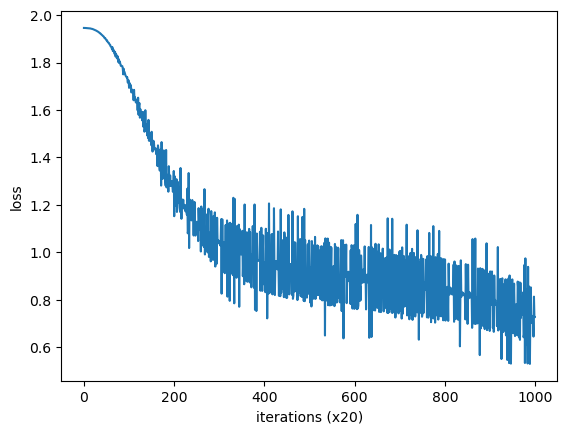

you [-1.1181744  1.1374502  0.9331635  1.5262753  0.9480893]
say [ 1.1094605 -1.0934782 -1.1335863  1.2735984 -1.1110693]
goodbye [-0.7325957   0.7743871   0.9848742   0.33548537  0.97482336]
and [ 0.8579804 -0.8483737 -0.7167006  2.0062559 -0.7287622]
i [-0.7468175   0.775734    0.9766399   0.3529076   0.97119004]
hello [-1.1395253  1.1193454  0.9288013  1.523452   0.9609732]
. [ 1.1163473  -1.0812362  -1.2409614  -0.60069376 -1.2404716 ]


In [26]:
import sys
sys.path.append('..')  # 親ディレクトリのファイルをインポートするための設定
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

パラメータの更新には、Adamというアルゴリズムを適用。<br>
図で示したとおり学習するにつれて損失が減少。<br>
ここから学習が終わったパラメータを確認する。<br>

In [39]:
# tensorflow
import tensorflow as tf

class SimpleCBOW(tf.keras.Model):
    def __init__(self, vocab_size, hidden_size):
        super(SimpleCBOW, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        # 埋め込み
        self.in_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=hidden_size)

        # 出力重み
        self.out_weight = self.add_weight(
            shape=(hidden_size, vocab_size),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
            trainable=True
        )

        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def call(self, contexts, target, training=False):
        # contexts: shape (batch_size, 2)
        h0 = self.in_embedding(contexts[:, 0])  # (batch_size, hidden_size)
        h1 = self.in_embedding(contexts[:, 1])
        h = 0.5 * (h0 + h1)                      # (batch_size, hidden_size)

        score = tf.matmul(h, self.out_weight)   # (batch_size, vocab_size)

        loss = self.loss_fn(target, score)      # target: shape (batch_size,)
        return loss, score

    @property
    def word_vecs(self):
        return self.in_embedding.weights[0]

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCBOW(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(SimpleCBOW, self).__init__()
        self.in_embedding = nn.Embedding(vocab_size, hidden_size)
        self.out_weight = nn.Parameter(torch.randn(hidden_size, vocab_size) * 0.01)

    def forward(self, contexts, target):
        h0 = self.in_embedding(contexts[:, 0])
        h1 = self.in_embedding(contexts[:, 1])
        h = 0.5 * (h0 + h1)

        score = torch.matmul(h, self.out_weight)  # (batch_size, vocab_size)

        loss = F.cross_entropy(score, target)     # target: (batch_size,)
        return loss, score

    @property
    def word_vecs(self):
        return self.in_embedding.weight.data

In [27]:
word_vecs=model.word_vecs
for word_id, word in id_to_word.items():
    print(word,word_vecs[word_id])

you [-1.1181744  1.1374502  0.9331635  1.5262753  0.9480893]
say [ 1.1094605 -1.0934782 -1.1335863  1.2735984 -1.1110693]
goodbye [-0.7325957   0.7743871   0.9848742   0.33548537  0.97482336]
and [ 0.8579804 -0.8483737 -0.7167006  2.0062559 -0.7287622]
i [-0.7468175   0.775734    0.9766399   0.3529076   0.97119004]
hello [-1.1395253  1.1193454  0.9288013  1.523452   0.9609732]
. [ 1.1163473  -1.0812362  -1.2409614  -0.60069376 -1.2404716 ]


## 3.5.1 CBOWモデルと確率

これまでword3vecのCBOWモデルについて見てきた。<br>
これを確立の観点から見る。<br>
同時確率を$P(A,B)$、事後確率を$P(A|B)$とする時<br>
CBOWモデルを確率に沿って記載すると<br>
$P(w_{t}|w_{t-1},w_{t+1})$となり<br>
これは$w_{t-1}$と$w_{t+1}$が起こったときに$w_{t}$が起こる確率と解釈できる。<br>
これを用いることで損失関数に対しても
$$
L=-\sum_{k}t_{k}logy_{k}=-logP(w_{t}|w_{t-1},w_{t+1})
$$
とすることができる。（**負の対数尤度**）

これをコーパス全体に拡張すると
$$
L=-\frac{1}{T}\sum_{t=1}^{T}logP(w_{t}|w_{t-1},w_{t+1})
$$
となる。

## 3.5.2 skip-gramモデル

前にも述べたとおりword2vecでは2つのモデルが提案される。
これまでのものとskip-gramモデルである。
こちらはCBOWのコンテキストとターゲットを逆転させたモデルである。
この場合、ターゲットからコンテキストを推測することとなる。

<img src="zerotuku2-3-24.png">

このときのモデルの損失関数は
$$
L=-\frac{1}{T}\sum_{t=1}^{T}(logP(w_{t-1}|w_{t})+logP(w_{t+1}|w_{t}))
$$

此の2つのモデルを比べた時
単語の分散表現の精度の点においてskip-gramのほうがより良い結果を求めやすい。
ただし、学習の速度としてはCBOWのほうが早い。

## 3.5.3 カウントベースvs推論ベース

単語の類似性に対する定量的な評価に関しては
推論ベースとカウントベースでは優劣がつけられない。

しかし語彙を追加するケースではパラメータの再学習ができる点で
推論ベースの手法のほうが効率的と言える。